In [16]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [4]:
cs_df = pd.read_excel("Online Retail.xlsx")

# Data Cleaning

In [6]:
# Tách dữ liệu theo 1 đơn vị địa lý
cs_df = cs_df[cs_df.Country == "United Kingdom"]

# Tách dữ liệu theo tổng số tiền
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.amount<0)]
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
cs_df = cs_df[~(cs_df.CustomerID.isnull())]
cs_df.shape

(354345, 9)

## Recency (Giao dịch gần nhất)

In [53]:
# Khởi tạo mốc thời điểm làm tham chiếu
refrence_date = cs_df.InvoiceDate.max()
refrence_date = refrence_date + datetime.timedelta(days = 1)
refrence_date

Timestamp('2011-12-10 12:49:00')

In [55]:
cs_df['days_since_last_purchase'] = refrence_date - cs_df.InvoiceDate
cs_df['days_since_last_purchase_num'] = cs_df['days_since_last_purchase'].astype('timedelta64[D]')

customer_history_df = cs_df.groupby("CustomerID").min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
customer_history_df.rename(columns={'days_since_last_purchase_num':'recency'}, inplace=True)
customer_history_df.recency.describe()

count    3921.000000
mean       92.188472
std        99.528995
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: recency, dtype: float64

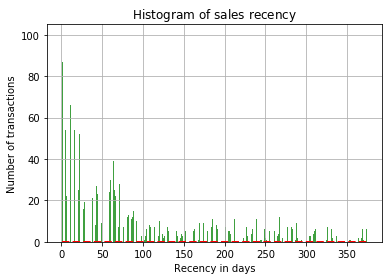

In [58]:

x = customer_history_df.recency
mu = np.mean(customer_history_df.recency)
sigma = math.sqrt(np.var(customer_history_df.recency))
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.rcParams["figure.figsize"] = (10,8)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')
plt.grid(True)
plt.show()

## Frequency and Monetary value

In [59]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val, how='outer')
customer_history_df.amount = customer_history_df.amount+0.001
customer_freq = cs_df[['CustomerID', 'amount']].groupby("CustomerID").count().reset_index()
customer_freq.rename(columns={'amount':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq, how='outer')
customer_history_df.head()

,CustomerID,recency,amount,frequency
0,12346.0,326.0,77183.601,1
1,12747.0,2.0,4196.011,103
2,12748.0,1.0,33719.731,4596
3,12749.0,4.0,4090.881,199
4,12820.0,3.0,942.341,59


## Data Preprocessing

In [60]:
from sklearn import preprocessing 
import math

customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', "recency_log", "frequency_log"]

X = customer_history_df[feature_vector].as_matrix()
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

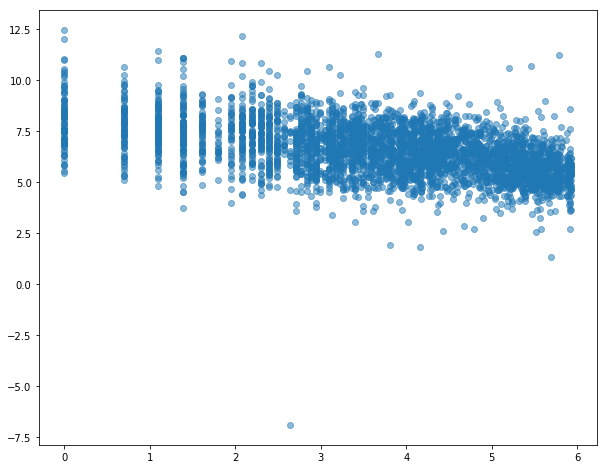

In [61]:
plt.scatter(customer_history_df.recency_log, customer_history_df.amount_log,alpha=0.5)
plt.show()

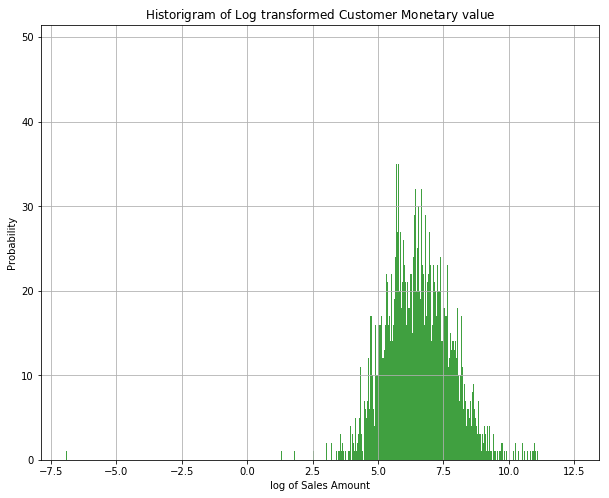

In [63]:
x = customer_history_df.amount_log
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
plt.xlabel("log of Sales Amount")
plt.ylabel("Probability")
plt.title(r"$\mathrm{Historigram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $")
plt.grid(True)
plt.show()

Text(0.5,0,'Monetary')

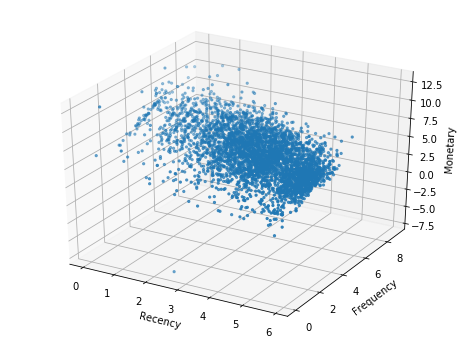

In [67]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection= '3d')

xs = customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

## Clustering for Segments

### Cluster Analysis

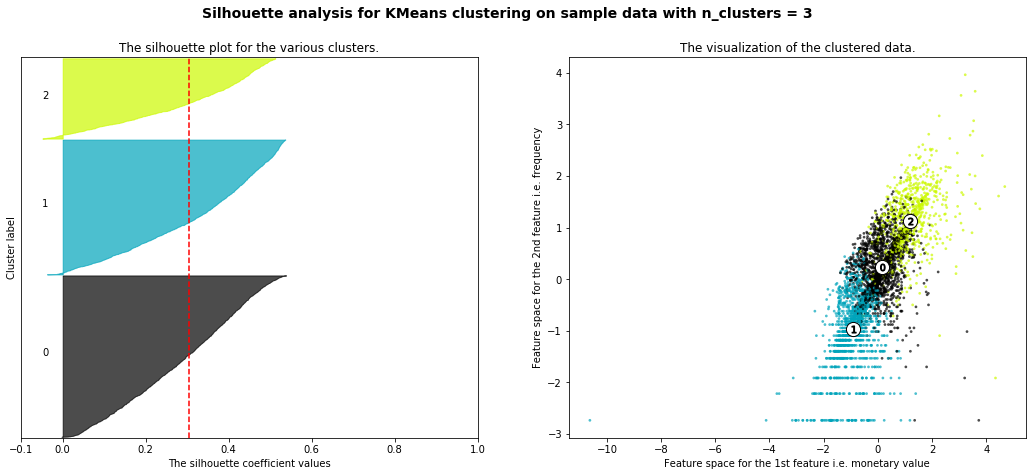

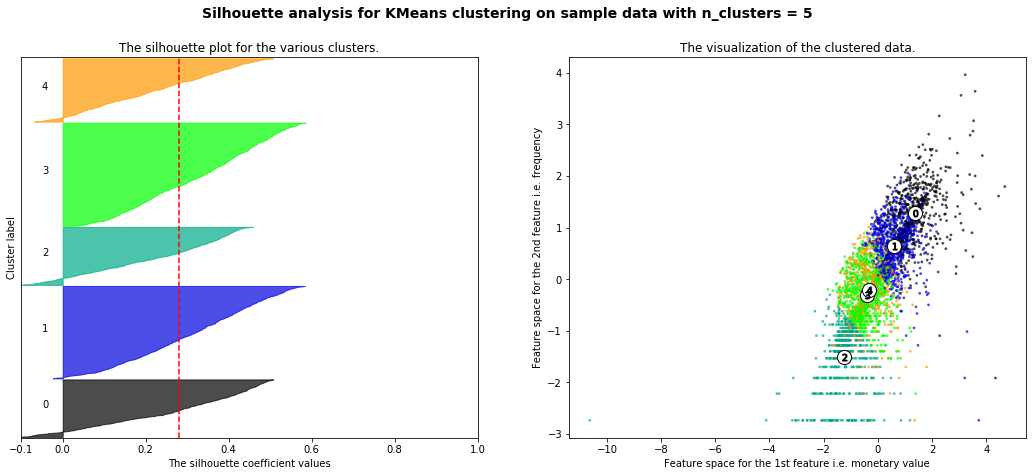

In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = X_scaled

cluster_centers = dict()

for n_clusters in range(3,6,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax2 = plt.subplot(111, projection='3d')
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                       'silhouette_score':silhouette_avg}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [72]:
for i in range(3, 6, 2):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed), columns=feature_vector))
    print("Silhouette Score cluster {} is {}".format(i, cluster_centers[i]['silhouette_score']))
    print()

for 3 number of clusters
    amount_log  recency_log  frequency_log
0   843.937271    44.083222      53.920633
1   221.236034   121.766072      10.668661
2  3159.294272     7.196647     177.789098
Silhouette Score cluster 3 is 0.30437444714898737

for 5 number of clusters
    amount_log  recency_log  frequency_log
0  3905.544371     5.627973     214.465989
1  1502.519606    46.880212      92.306262
2   142.867249   126.546751       5.147370
3   408.235418   139.056216      25.530424
4   464.371885    13.386419      29.581298
Silhouette Score cluster 5 is 0.27958641427323727

